## retail price optimization

<img src="price.webp" alt="picture" width="350">

*`Background`*

Price optimization is using historical data to identify the most appropriate price of a product or a service that maximizes the company’s profitability. There are numerous factors like demography, operating costs, survey data, etc that play a role in efficient pricing, it also depends on the nature of businesses and the product that is served. 

The business regularly adds/upgrades features to bring more value to the product and this obviously has a cost associated with it in terms of effort, time, and most importantly companies reputation.

As a result, it is important to understand the correct pricing, a little too high, you lose your customers and slight underpricing will result in loss of revenue. Price optimization helps businesses strike the right balance of efficient pricing, achieving profit objectives, and also serve their customers.

*detail columns:*

`packages`

In [1]:
# general
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os, yaml, requests
import numpy as np

# temporal decompose
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

# stas models
import statsmodels.api as sm
from statsmodels.stats import descriptivestats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('ggplot')

# sctatter plot
from pandas.plotting import scatter_matrix

# warnings
import warnings
warnings.filterwarnings('ignore')

# shap
import shap

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


`functions`

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

`get data`

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

In [4]:
q = """
    select
            *
    from
            kaggle_data.price_optimization.data_gas_station;
"""

In [5]:
df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day
1,2019-06-09,9,6,2019,diesel,16,100.000,1,100.000,21.09,26.1,7,1,normal day
2,2019-06-09,9,6,2019,diesel,19,9.483,1,9.483,21.09,26.1,7,1,normal day


The initial step involves delving deep into the data and scrutinizing various aspects. The foremost task is to ascertain whether the data contains any null values and the info about it.

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21465 entries, 0 to 21464
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          21465 non-null  datetime64[ns]
 1   day           21465 non-null  int64         
 2   month         21465 non-null  int64         
 3   year          21465 non-null  int64         
 4   product       21465 non-null  object        
 5   hour          21465 non-null  int64         
 6   volume        21465 non-null  float64       
 7   transactions  21465 non-null  int64         
 8   avg_by_tkt    21465 non-null  float64       
 9   price         21465 non-null  float64       
 10  raining_days  21465 non-null  float64       
 11  weekday       21465 non-null  int64         
 12  is_weekend    21465 non-null  int64         
 13  holiday_name  21465 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(7), object(2)
memory usage: 2.3+ MB


In [7]:
df_raw.isnull().sum()

date            0
day             0
month           0
year            0
product         0
hour            0
volume          0
transactions    0
avg_by_tkt      0
price           0
raining_days    0
weekday         0
is_weekend      0
holiday_name    0
dtype: int64

*create a copy form the original data*

In [8]:
df=df_raw.copy()

describe the data

In [9]:
df[['volume', 'transactions', 'avg_by_tkt', 'price']].describe()

,volume,transactions,avg_by_tkt,price
count,21465.000000,21465.000000,21465.000000,21465.000000
mean,268.756552,12.358118,40.539617,18.964805
std,247.898429,13.391866,66.234476,1.972111
min,0.033000,1.000000,0.007200,12.890000
25%,81.679000,2.000000,15.508237,17.950000
50%,186.347000,6.000000,20.657800,19.190000
75%,400.676000,19.000000,31.527889,20.750000
max,2375.347000,68.000000,555.309000,21.170000


*In the realm of data analysis, it's a well-established principle that correlation does not necessarily indicate **causation.** However, it does provide valuable insights into the connections between various factors. In our current context, we can identify correlations between **prices** and factors such as rainy days or holidays. For example, we may explore whether there's a **leader-follower pricing strategy** in effect, or if sales volumes are influenced by weekend days.*

<img src="correlation_causation.avif" alt="causation" width="450">

In [10]:
# add holiday flag
df['holiday_flag']=np.where(df['holiday_name']!='normal day', 1, 0)

In [11]:
df.head(1)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,holiday_flag
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day,0


In [12]:
cols_corr=['price', 'volume', 'hour', 'raining_days', 'weekday', 'is_weekend', 'holiday_flag']
corr_matrix=df[cols_corr].corr()
corr_matrix['volume'].sort_values(ascending=False)

volume          1.000000
price           0.076096
is_weekend     -0.001411
hour           -0.001466
weekday        -0.019056
holiday_flag   -0.027104
raining_days   -0.150465
Name: volume, dtype: float64

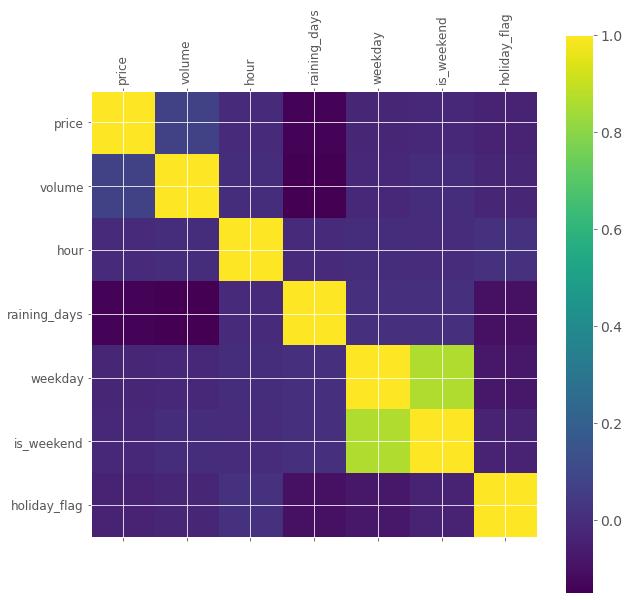

In [13]:
f = plt.figure(figsize=(10, 10))
plt.matshow(corr_matrix, fignum=f.number)
plt.xticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=12, rotation=90)
plt.yticks(range(corr_matrix.shape[1]), corr_matrix.columns, fontsize=12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In our comprehensive correlation analysis, we've uncovered a surprising revelation: there appears to be no significant relationship between price and volume.<br>

One intriguing observation emerges amidst our analysis: a noticeable decrease in trading volume during rainy days.<br>

While this pattern raises eyebrows, it's essential to tread carefully before attributing causality. Despite the apparent correlation, our research does not unveil any concrete evidence of a causal link between weather conditions and trading volume. Furthermore, our scrutiny extends to the impact of holidays and weekends on trading activity. Contrary to popular belief, our analysis fails to establish a significant correlation between trading volume and the occurrence of holidays or weekdays. 

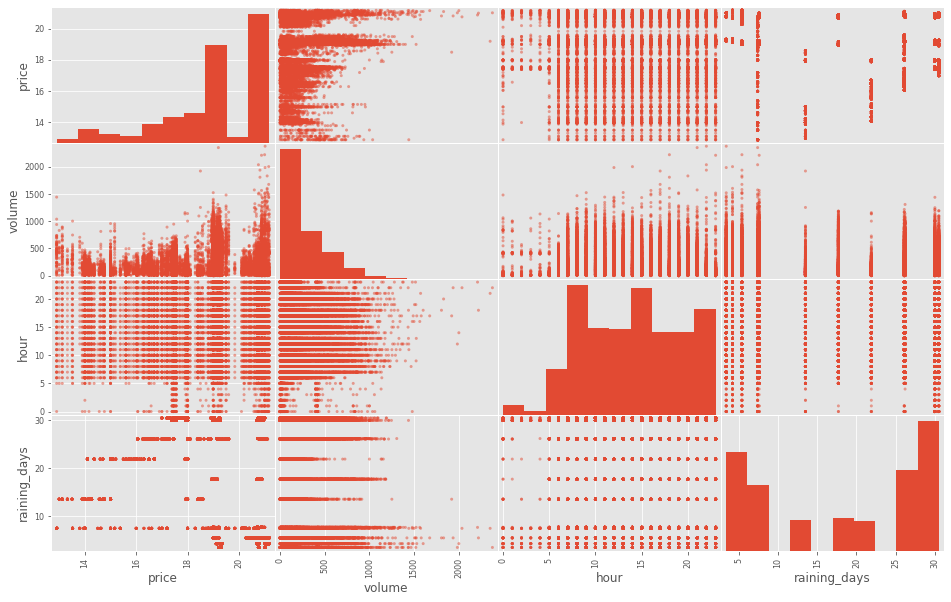

In [14]:
features = ['price', 'volume', 'hour', 'raining_days']
scatter_matrix(df[features], figsize = (16, 10))
plt.show()

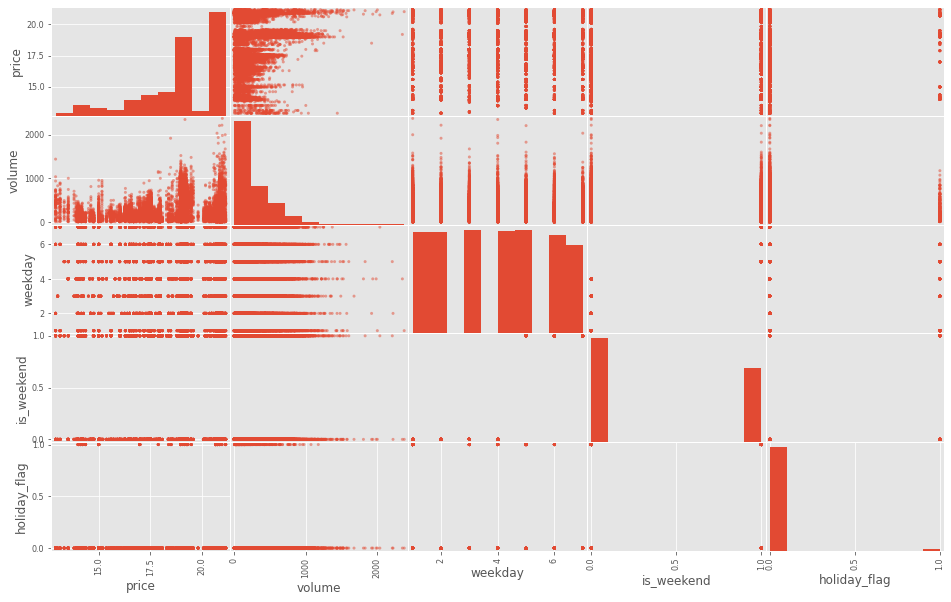

In [15]:
features = ['price', 'volume', 'weekday', 'is_weekend', 'holiday_flag']
scatter_matrix(df[features], figsize = (16, 10))
plt.show()

**`temporal analysis`**

In [16]:
df.head(1)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,holiday_flag
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day,0


In [17]:
cols=['date', 'product', 'volume', 'price']
summary_sales=df[cols].groupby(by=['date', 'product'], as_index=False).agg({'volume':'sum', 'price':'mean'})

In [18]:
summary_sales

,date,product,volume,price
0,2019-06-09,diesel,220.607,21.09
1,2019-06-09,premium,0.105,21.11
2,2019-06-09,regular,9790.018,19.59
3,2019-06-10,diesel,2605.011,21.09
4,2019-06-10,regular,11803.856,19.59
...,...,...,...,...
1341,2020-08-29,premium,3538.029,17.93
1342,2020-08-29,regular,6952.374,17.39
1343,2020-08-30,diesel,238.547,18.99
1344,2020-08-30,premium,2395.380,17.93


In [19]:
products=summary_sales['product'].unique()

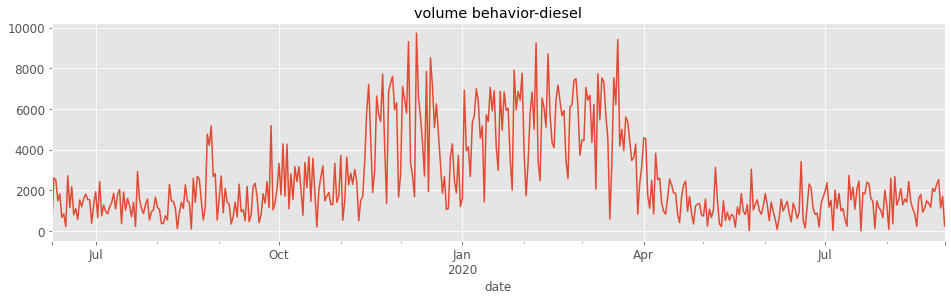

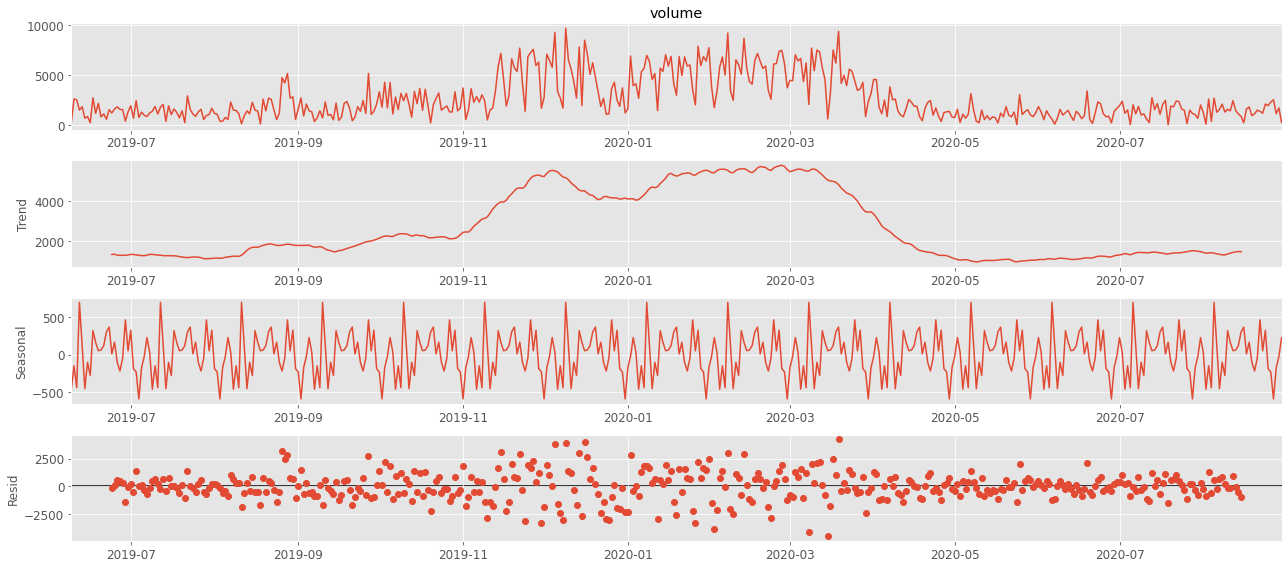

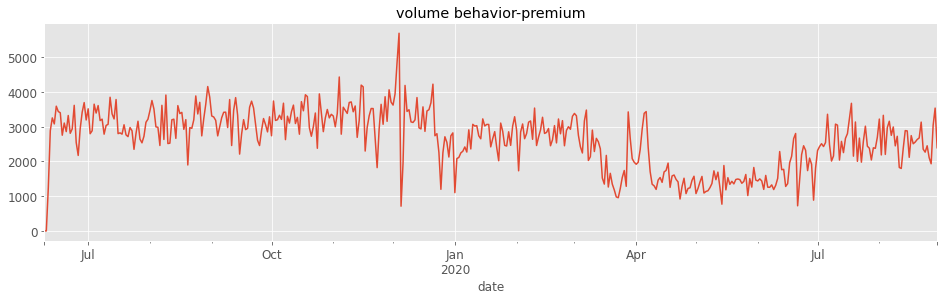

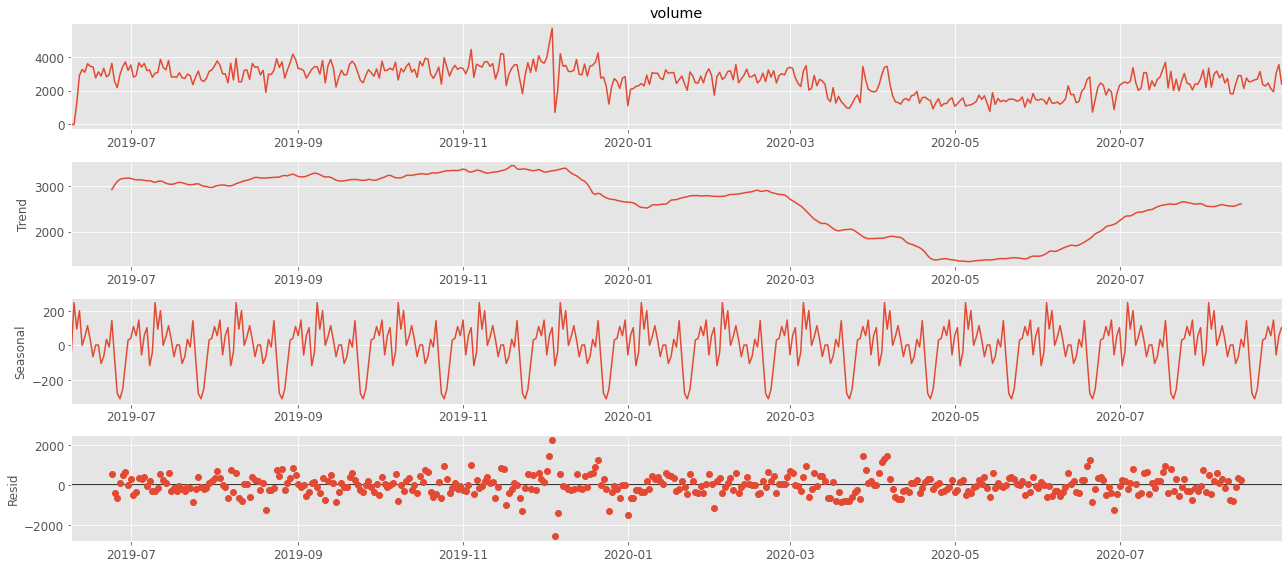

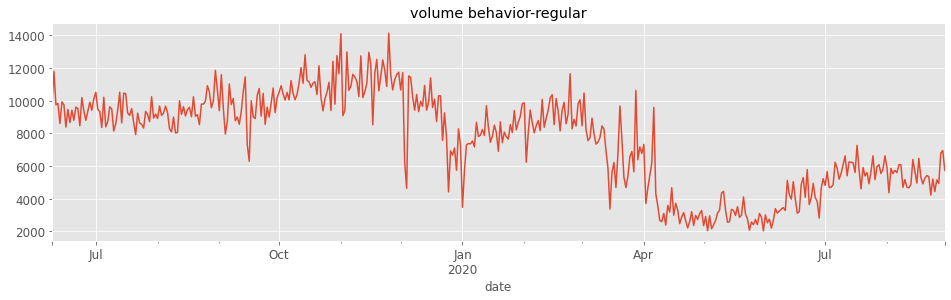

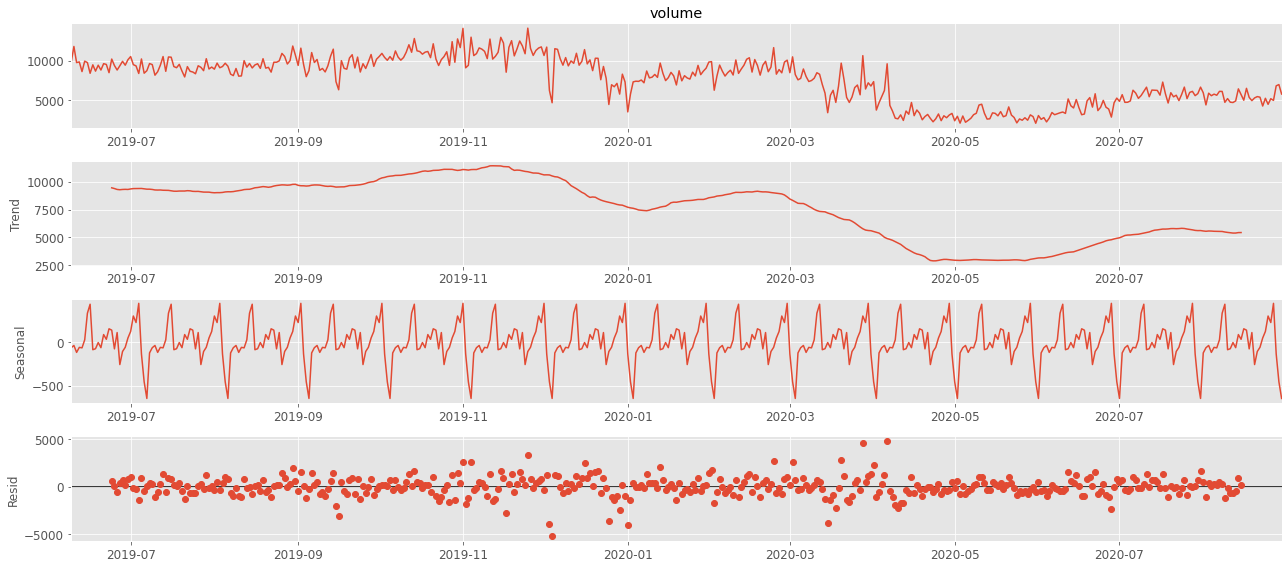

In [20]:
for p in products:
    df_tempral_raw=summary_sales[summary_sales['product']==p].set_index('date')
    y=df_tempral_raw['volume'].resample('D').sum()

    # plot data
    y.plot(figsize = (16,4))
    plt.title('volume behavior-' + p)
    plt.show()
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 18, 8

    decomposition = sm.tsa.seasonal_decompose(y, period = 30)
    fig = decomposition.plot()
    plt.show()

It's evident that sales remained consistent throughout the latter part of 2019. However, there was a noticeable decline in gasoline sales during the initial months of 2020, while diesel sales appeared to maintain their strength. 

To truly understand these fluctuations, a comprehensive causal analysis is imperative. Factors such as pricing dynamics must be thoroughly examined, alongside the potential impact of the COVID-19 pandemic, particularly as sales began to be affected from March onwards. This deeper investigation will shed light on the intricacies of the market dynamics at play.

**`adjust the dataset`**

*add the covid column*

In [21]:
df['covid']=np.where(df['date']>'2020-03-20', 1, 0)

select only the product *regular*

In [22]:
df_reg=df[df['product']==products[2]]
print(products[2])

regular


In [23]:
cols=['date', 'holiday_name', 'year', 'product']
df_reg.drop(columns=cols, inplace=True)

In [24]:
df_reg.head(1)

,day,month,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_flag,covid
8,9,6,6,84.356,5,16.8712,19.59,26.1,7,1,0,0


**`analysis`**

In [25]:
sum_reg=df[['date', 'volume', 'price']][df['product']=='regular'].groupby(as_index=False, 
                                                                          by='date').agg({'volume':'sum', 'price':'mean'})

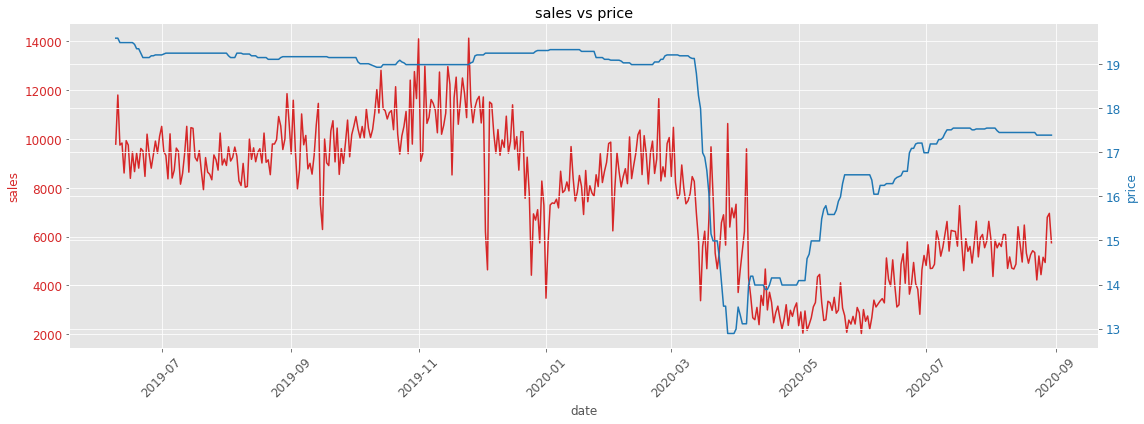

In [26]:
# Crear figura y eje primario con un tamaño específico
fig, ax1 = plt.subplots(figsize=(16, 6))

# Configurar el eje primario (eje de las ventas)
color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('sales', color=color)
ax1.plot(sum_reg['date'], sum_reg['volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Modificar la rotación de los xtick del eje primario
ax1.tick_params(axis='x', rotation=45)  # Rotación de 45 grados

# Crear eje secundario (para la cantidad vendida)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('price', color=color)
ax2.plot(sum_reg['date'], sum_reg['price'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Título y mostrar gráfico
plt.title('sales vs price')
fig.tight_layout()  # Para que no haya solapamientos en los labels
plt.show()

**`density function`**

SKIPPED kapp3 distribution (taking more than 30 seconds)
kapp3 was not fitted. no parameters available


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,9.552182e-07,1702.198355,1730.333245,inf,0.021906,6.324311e-04
chi,4.006085e-06,1642.987135,1664.088303,inf,0.063200,1.517056e-29
nakagami,4.006087e-06,1642.987213,1664.088381,inf,0.063200,1.517104e-29
beta,4.242454e-06,1704.236748,1732.371638,inf,0.057050,3.754497e-24
kapp3,inf,inf,inf,inf,NaN,NaN


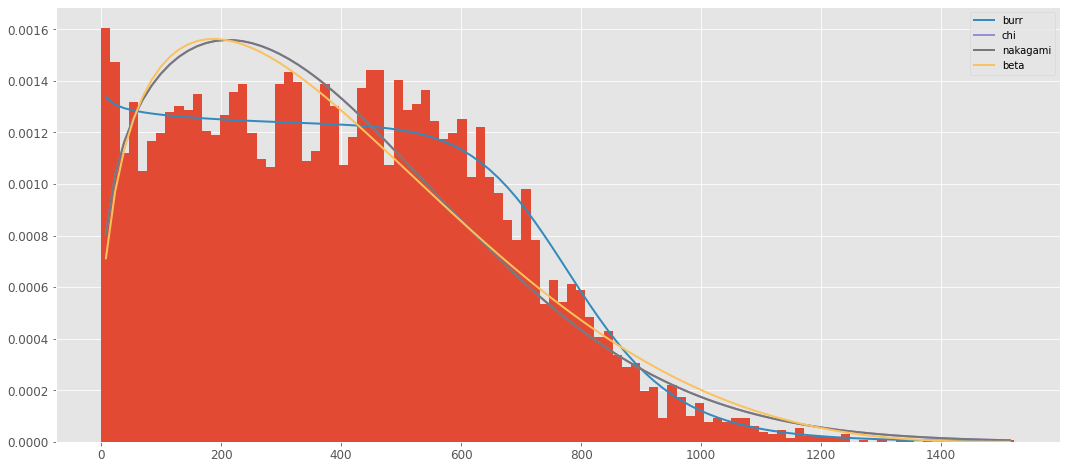

In [27]:
from fitter import Fitter
f = Fitter(df_reg['volume'], distributions=['kapp3', 'burr', 'chi', 'nakagami', 'beta'])
f.fit()
f.summary()

**`elasticity`**

In dissecting the data presented in the charts above, it becomes clear that distinct products showcase varying degrees of demand elasticity. Among them, one product stands out with perfectly elastic demand, while others demonstrate inelasticity.

Moving forward, our focus lies in determining the elasticity of these products, particularly in light of the unprecedented events like the ongoing pandemic. By incorporating the temporal dimension of the pandemic's occurrence, we aim to unveil its profound impact on demand elasticity.

*price vs sales*

Exploring the dynamics of product elasticity amidst the backdrop of a pandemic-induced lockdown reveals intriguing insights. Observing the chart below, it becomes evident that the product exhibits characteristics of inelasticity. Despite a higher price point, sales remain robust, indicating a lesser degree of responsiveness to price changes. However, it's crucial to note that this trend is intricately tied to the unique circumstances of the lockdown imposed due to the pandemic. Let's delve deeper into the implications of this phenomenon.

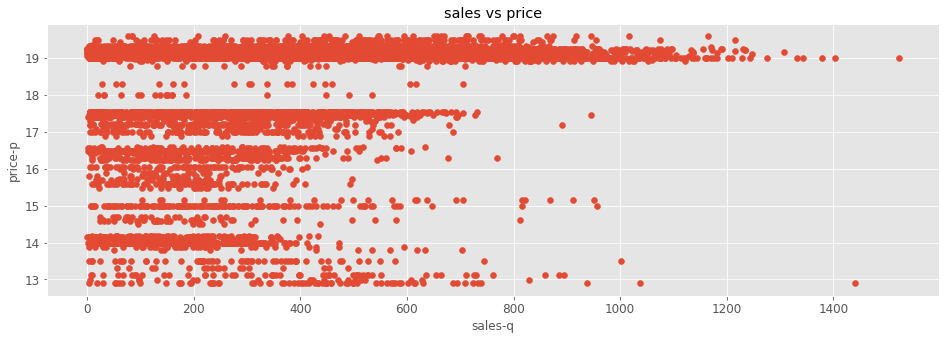

In [28]:
plt.figure(figsize=(16, 5))
plt.scatter(df_reg['volume'], df_reg['price'])
plt.title('sales vs price')
plt.xlabel('sales-q')
plt.ylabel('price-p')
plt.show()

In [29]:
# scikit learn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# econml 

from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

# graphs
from networkx.drawing.nx_pydot import to_pydot

*split the data*

In [30]:
train, test = train_test_split(df_reg, test_size=0.2, random_state=42)

_define estimator inputs_

In [31]:
Y_train=train['volume']                            # outcome of interest
T_train=train['price']                             # intervention or treatment
X_train=train.drop(columns=['volume', 'price'])    # features

# get log_T & log_Y
log_T_train=np.log(T_train)
log_Y_train=np.log(Y_train)

# =====================================================================================================================
# =====================================================================================================================
Y_test=test['volume']         # outcome of interest
T_test=test['price']          # intervention or treatment
X_test=test.drop(columns=['volume', 'price'])   # features

# get log_T & log_Y
log_T_test=np.log(T_test)
log_Y_test=np.log(Y_test)

*econml model*

In [32]:
est = LinearDML(model_y=GradientBoostingRegressor(), 
                model_t=GradientBoostingRegressor(),
                featurizer=PolynomialFeatures(degree=3, include_bias=False))
est.fit(log_Y_train, log_T_train, X=X_train, inference="statsmodels")

In [33]:
est.score(Y=log_Y_test, T=log_T_test, X=X_test)

0.0017619965407802325

In [34]:
te_pred=est.effect(X_test)
te_pred_interval=est.effect_interval(X_test)

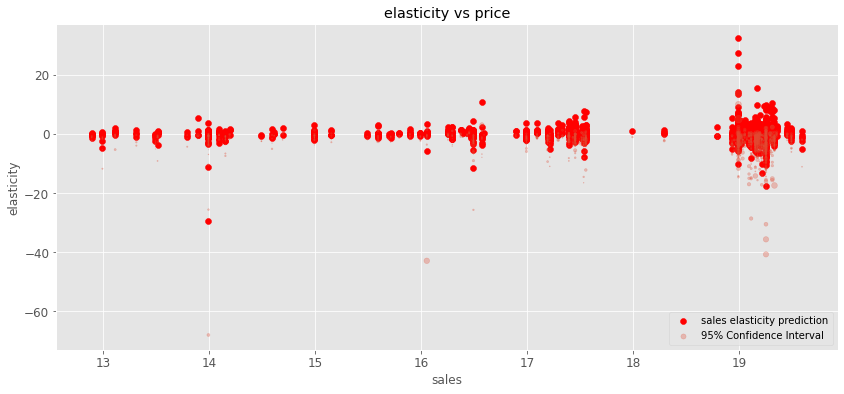

In [35]:
plt.figure(figsize=(14, 6))

plt.scatter(T_test.values.flatten(), te_pred, color='r', label="sales elasticity prediction")
plt.scatter(T_test.values.flatten(),
                 te_pred_interval[0],
                 te_pred_interval[1],
                 alpha=0.3,
                 label="95% Confidence Interval")

plt.xlabel("sales")
plt.ylabel("elasticity")
plt.title("elasticity vs price")

plt.legend(loc="lower right")
plt.show()

In [36]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
day,1.264,0.776,1.63,0.103,-0.256,2.785
month,-3.52,4.387,-0.802,0.422,-12.118,5.079
hour,-0.469,1.346,-0.349,0.727,-3.107,2.169
transactions,-0.812,0.485,-1.676,0.094,-1.762,0.138
avg_by_tkt,-1.728,0.829,-2.085,0.037,-3.352,-0.104
raining_days,13.803,1.528,9.033,0.0,10.808,16.798
weekday,-12.891,5.978,-2.156,0.031,-24.608,-1.173
is_weekend,24.345,14.392,1.692,0.091,-3.862,52.552
holiday_flag,1.084,0.354,3.064,0.002,0.39,1.777
covid,-74.902,2.098,-35.701,0.0,-79.014,-70.79


In [37]:
est = CausalForestDML(
    model_y=GradientBoostingRegressor(), 
    model_t=GradientBoostingRegressor())


est.fit(log_Y_train, log_T_train, X=X_train, inference="blb")

te_pred = est.effect(X_test)
te_pred_interval = est.effect_interval(X_test)

In [38]:
est.score(Y=log_Y_test, T=log_T_test, X=X_test)

0.0016100021548524244

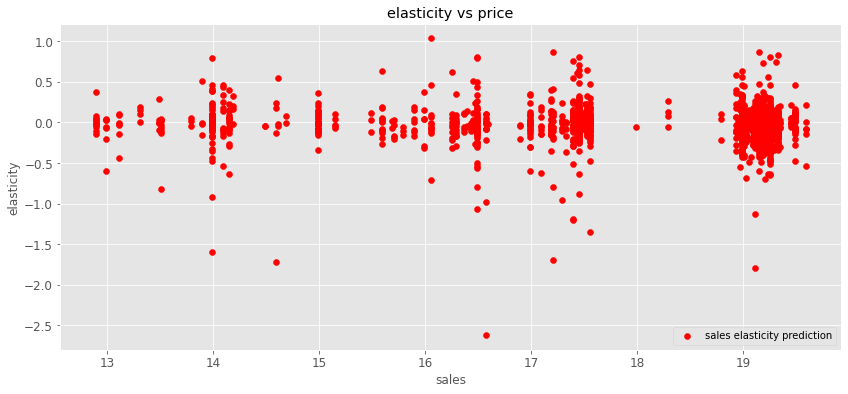

In [39]:
plt.figure(figsize=(14, 6))
plt.scatter(T_test.values.flatten(), te_pred, color='r', label="sales elasticity prediction")

plt.xlabel("sales")
plt.ylabel("elasticity")
plt.title("elasticity vs price")

plt.legend(loc="lower right")
plt.show()

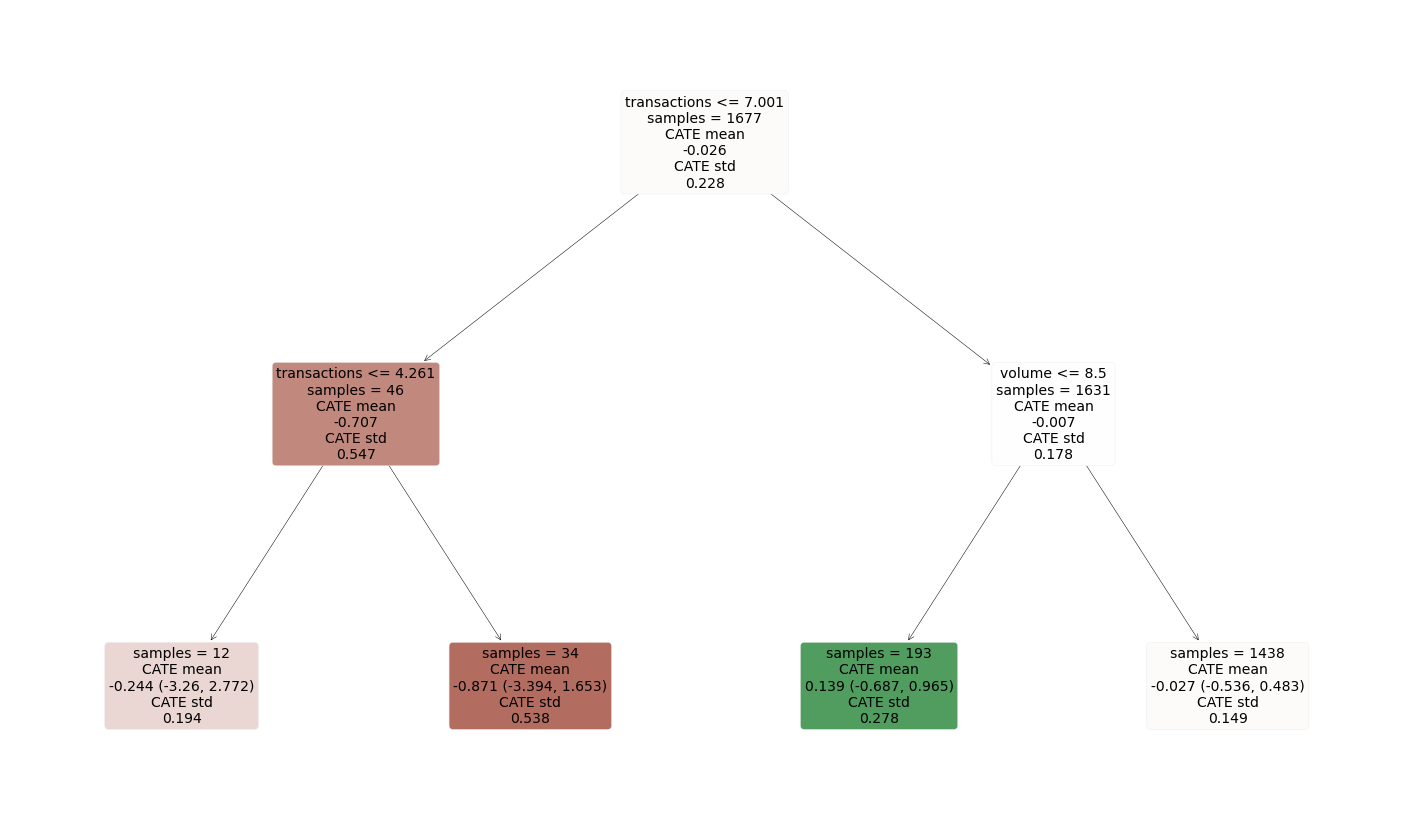

In [40]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
intrp.interpret(est, X_test)
plt.figure(figsize=(25, 15))
intrp.plot(feature_names=test.columns, fontsize=14)

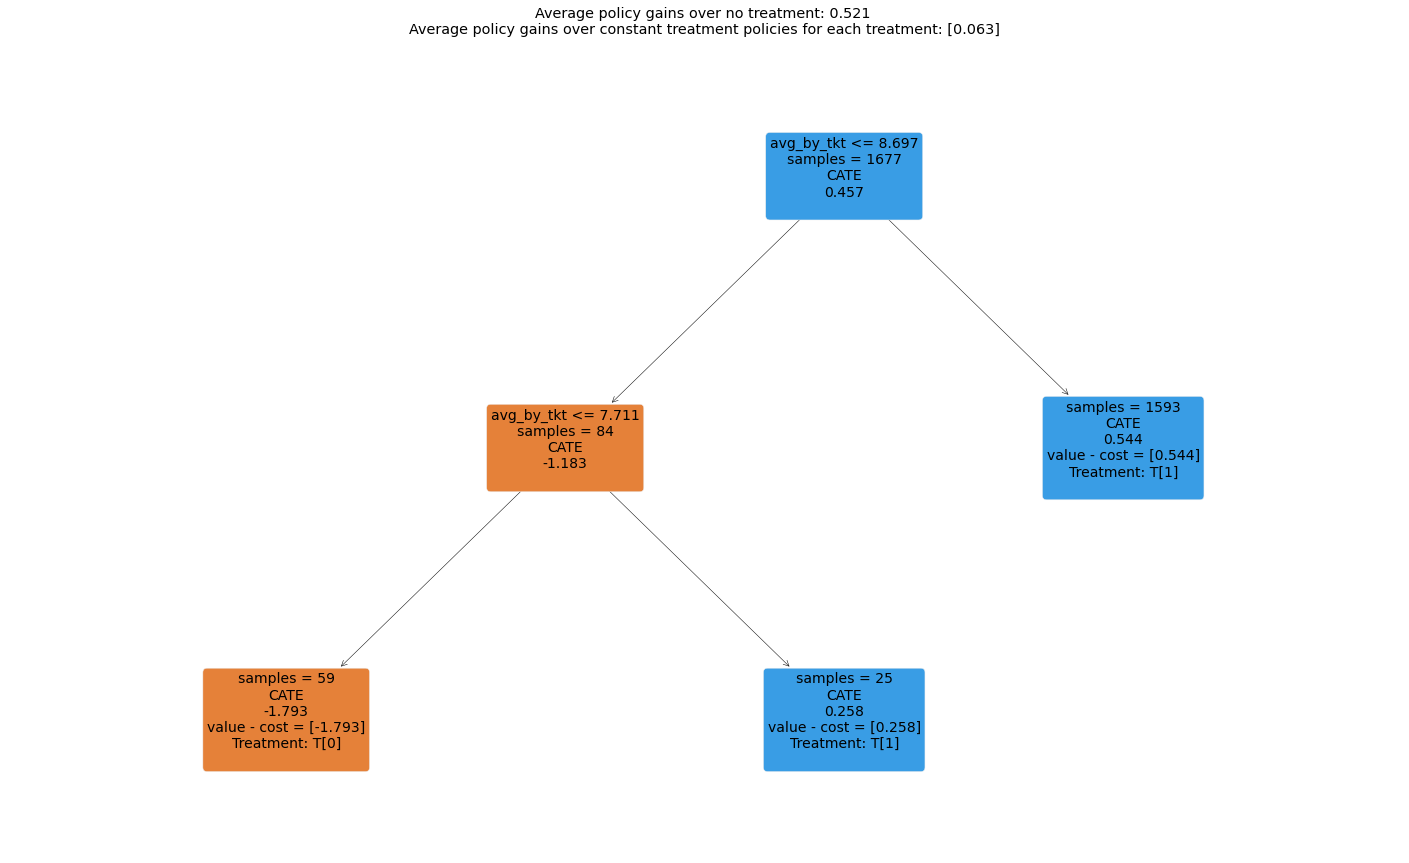

In [43]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=0.001)
intrp.interpret(est, X_test, sample_treatment_costs=-1)
plt.figure(figsize=(25, 15))
intrp.plot(feature_names=X_test.columns, fontsize=14)